** Importing Libraries **

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from prettytable import PrettyTable

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

from scipy import *
from scipy.sparse import *

In [2]:
path = 'Reviews.csv'
df = pd.read_csv(path)
data = df

In [3]:
#Removing Neural reviews
data_s = data[data['Score']!=3]

#Updating Score to 0 or 1
def partition(x):
    if x<3:
        return 0
    return 1

score_upd = data_s['Score']
temp = score_upd.map(partition)
data_s['Score'] = temp

In [4]:
final_data = data_s.drop_duplicates(subset=('UserId','ProfileName','Time','Text'))
final = final_data[final_data['HelpfulnessNumerator']<=final_data['HelpfulnessDenominator']]

In [5]:
final = final.sort_values(['Time'], axis=0)   #TIme based sorting
final = final.head(100000)

In [6]:
final_X = final['Text']
final_y = final['Score']

** Data preprocessing

* stopword
* stemming
* Punctuations removal

In [7]:
import re
temp_1 =[]
snow = nltk.stem.SnowballStemmer('english')
i = 0
N = len(final_X)
for sentence in final_X:
    sentence = sentence.lower()
    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', sentence)        #Removing HTML tags
    sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)        #Removing Punctuations
    
    words = [snow.stem(word) for word in sentence.split() if word not in stopwords.words('english')]        #Splitting the words
    temp_1.append(words)                                                                            # and doing stemming
    print("{0:.2f} %".format((i/N)*100),end ='\r')
    i = i+1
    
final_X = temp_1   

In [8]:
# Joining the splitted words back to sentence

sent = []
for row in final_X:
    seq = ''
    for word in row:
        seq = seq + ' ' + word
    sent.append(seq)

final_X = sent

In [9]:
#Splitting data into train and test
#Splitting data into train and test
X_train = final_X[:75000]
X_test = final_X[75000:]
y_train = final_y[:75000]
y_test = final_y[75000:]

## Logistic Regression on BoW

In [10]:
# Bag of Words

count_vect = CountVectorizer(max_features = 2000, dtype='float')
bow_X_train = count_vect.fit_transform(X_train)
bow_X_test = count_vect.transform(X_test)

### GridSearchCV

In [11]:
lam = [0.001,0.01,0.1,1,10]
clf = LogisticRegression()
param_grid = {'C':lam}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 5,n_jobs = 3)
grid.fit(bow_X_train, y_train)
print("best C = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_
optimal_a1 = a.get('C')

best C =  {'C': 1}
Accuracy on train data =  92.50933333333333


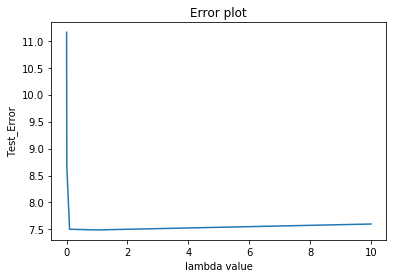

In [12]:
import matplotlib.pyplot as plt 

error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(lam, error)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()

** Using L2 Regularizer (By default its L2)**

In [13]:
clf = LogisticRegression(C = optimal_a1)

clf.fit(bow_X_train,y_train)

pred = clf.predict(bow_X_test)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred) * 100
rec1 = recall_score(y_test, pred) * 100
f11 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc1))
print('\nprecision=%f%%' % (pre1))
print('\nrecall=%f%%' % (rec1))
print('\nF1-Score=%f%%' % (f11))


Accuracy=91.864000%

precision=93.632223%

recall=97.182054%

F1-Score=95.374119%


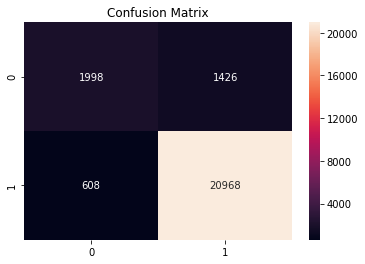

In [14]:
import seaborn as sns
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

** Using L1 Regularizer **

In [15]:
clf = LogisticRegression(C = optimal_a1 , penalty='l1')

clf.fit(bow_X_train,y_train)

pred = clf.predict(bow_X_test)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=91.872000%

precision=93.558884%

recall=97.279385%

F1-Score=95.382868%


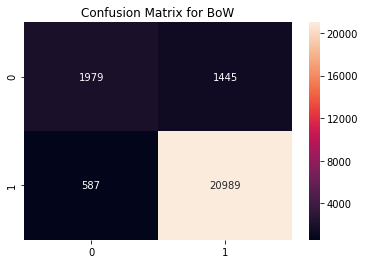

In [16]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for BoW')
plt.show()

In [17]:
x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Grid'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

x.add_row([cv,reg1,optimal_a1,acc1,err1,pre1,rec1,f11])
x.add_row([cv,reg2,optimal_a1,acc2,err2,pre2,rec2,f12])

print(x)

+------+-------------+---+-------------+---------------+--------------+-----------+-------------+
|  CV  | Regularizer | C | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------+-------------+---+-------------+---------------+--------------+-----------+-------------+
| Grid |      L2     | 1 |    91.86    |      8.14     |    93.63     |   97.18   |    95.37    |
| Grid |      L1     | 1 |    91.87    |      8.13     |    93.56     |   97.28   |    95.38    |
+------+-------------+---+-------------+---------------+--------------+-----------+-------------+


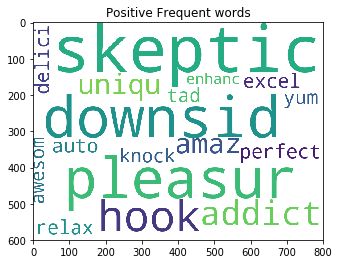

In [18]:
positive_log = np.array(list(map(abs,clf.coef_))).argsort()[0][1970:2000]

pos={}

for index in positive_log:
    for i in count_vect.vocabulary_:
        if count_vect.vocabulary_[i] == index:
            pos[i]=clf.coef_[0][index]
            

from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 600,
background_color ='white').generate_from_frequencies(pos)
plt.imshow(wordcloud)
plt.title("Positive Frequent words")
plt.show()

### RandomizedSearchCV

In [19]:
from scipy.stats import uniform
clf = LogisticRegression()
param_grid = { 'C':uniform()}
grid = RandomizedSearchCV(estimator = clf,param_distributions=param_grid ,cv = 5,n_jobs = 3)
grid.fit(bow_X_train, y_train)
print("best C = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_
optimal_a1 = a.get('C')

best C =  {'C': 0.37837950974696655}
Accuracy on train data =  92.58133333333333


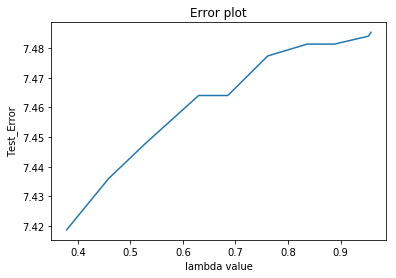

In [20]:
lam =[]
for i in range(10):
    lam.append(grid.cv_results_['params'][i]['C'])
ind = np.argsort(lam)
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
l_values=[]
err=[]
for i in ind:
    l_values.append(lam[i])
    err.append(error[i])
plt.plot(l_values, err)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()

** Using L2 Regularizer (By default its L2) **

In [21]:
clf = LogisticRegression(C = optimal_a1)

clf.fit(bow_X_train,y_train)

pred = clf.predict(bow_X_test)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred) * 100
rec1 = recall_score(y_test, pred) * 100
f11 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc1))
print('\nprecision=%f%%' % (pre1))
print('\nrecall=%f%%' % (rec1))
print('\nF1-Score=%f%%' % (f11))



Accuracy=91.972000%

precision=93.569934%

recall=97.390619%

F1-Score=95.442055%


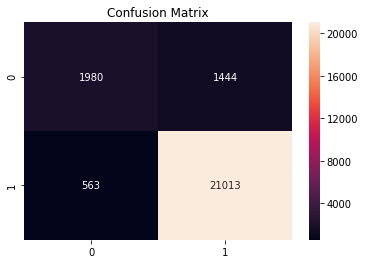

In [22]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

** Using L1 Regularizer **

In [116]:
clf = LogisticRegression(C = optimal_a1 , penalty='l1')

clf.fit(bow_X_train,y_train)

pred = clf.predict(bow_X_test)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))



Accuracy=91.932000%

precision=93.539914%

recall=97.376715%

F1-Score=95.419761%


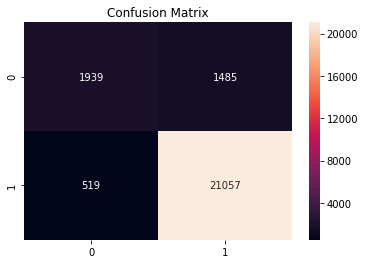

In [24]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [25]:
x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Random'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)


acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

x.add_row([cv,reg1,optimal_a1,acc1,err1,pre1,rec1,f11])
x.add_row([cv,reg2,optimal_a1,acc2,err2,pre2,rec2,f12])

print(x)

+--------+-------------+---------------------+-------------+---------------+--------------+-----------+-------------+
|   CV   | Regularizer |          C          | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+--------+-------------+---------------------+-------------+---------------+--------------+-----------+-------------+
| Random |      L2     | 0.37837950974696655 |    91.97    |      8.03     |    93.57     |   97.39   |    95.44    |
| Random |      L1     | 0.37837950974696655 |    91.98    |      8.02     |    93.41     |   97.59   |    95.46    |
+--------+-------------+---------------------+-------------+---------------+--------------+-----------+-------------+


## Perturbation Test ##

** Pertubation test means adding noise to one of the data point and comparing the difference b/w change in previous weights and New weights to find of collinearity. **

In [117]:
# to calculate percentage change for both weights

def Weight_change(Pre_weights,New_weights):
    ch = 0
    for i in range(Pre_weights.shape[0]):
        if Pre_weights[i] != New_weights[i]:
            ch += 1
    
    per = (ch / Pre_weights.shape[0])*100
    
    return per
        

# Calculating previous weights

pre_w = clf.coef_[0]

noise_data = bow_X_train.todense()
noise_data[1323] += 0.01

clf = LogisticRegression(C = optimal_a1 , penalty='l1')
clf.fit(noise_data,y_train)

new_w = clf.coef_[0]

per_Change = Weight_change(pre_w,new_w)

print(per_Change)

86.95


** Weights differ so much  we can say features are collinear **

** Increasing lambda value to see error reports and sparsity check on L1 regularizer.**
** As C Decreases Lambda value Increases **

In [32]:
clf = LogisticRegression(C=100, penalty='l1')
clf.fit(bow_X_train, y_train)

pred = clf.predict(bow_X_test)
ac1 = accuracy_score(y_test, pred) * 100
er1 = np.around(100 - ac1, decimals = 2)

w = clf.coef_
s1 = np.count_nonzero(w)

#======================================================================

clf = LogisticRegression(C=10, penalty='l1')
clf.fit(bow_X_train, y_train)

pred = clf.predict(bow_X_test)
ac2 = accuracy_score(y_test, pred) * 100
er2 = np.around(100 - ac2, decimals = 2)

w = clf.coef_
s2 = np.count_nonzero(w)

#======================================================================

clf = LogisticRegression(C=1, penalty='l1')
clf.fit(bow_X_train, y_train)

pred = clf.predict(bow_X_test)
ac3 = accuracy_score(y_test, pred) * 100
er3 = np.around(100 - ac3, decimals = 2)

w = clf.coef_
s3 = np.count_nonzero(w)

#======================================================================

clf = LogisticRegression(C=0.1, penalty='l1')
clf.fit(bow_X_train, y_train)

pred = clf.predict(bow_X_test)
ac4 = accuracy_score(y_test, pred) * 100
er4 = np.around(100 - ac4, decimals = 2)

w = clf.coef_
s4 = np.count_nonzero(w)

#======================================================================

clf = LogisticRegression(C=0.01, penalty='l1')
clf.fit(bow_X_train, y_train)

pred = clf.predict(bow_X_test)
ac5 = accuracy_score(y_test, pred) * 100
er5 = np.around(100 - ac5, decimals = 2)

w = clf.coef_
s5 = np.count_nonzero(w)

#======================================================================

** Sparsity is Number of Non-Zero elements in weight vector **

In [33]:
x = PrettyTable()

c = [100,10,1,0.1,0.01]

x.field_names = ['C','Train_Error(%)','Sparsity']

x.add_row([c[0],er1,s1])
x.add_row([c[1],er2,s2])
x.add_row([c[2],er3,s3])
x.add_row([c[3],er4,s4])
x.add_row([c[4],er5,s5])

print(x)

+------+----------------+----------+
|  C   | Train_Error(%) | Sparsity |
+------+----------------+----------+
| 100  |      8.18      |   1997   |
|  10  |      8.21      |   1975   |
|  1   |      8.13      |   1806   |
| 0.1  |      8.4       |   815    |
| 0.01 |     11.54      |   129    |
+------+----------------+----------+


## Logistic Regression on Tf-Idf

In [34]:
tf_idf = TfidfVectorizer(max_features=2000)
tf_X_train = tf_idf.fit_transform(X_train)
tf_X_test = tf_idf.transform(X_test)

### GridSearchCV

In [69]:
lam = [0.001,0.01,0.1,1,10]
clf = LogisticRegression()
param_grid = {'C':lam}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 5,n_jobs = 3)
grid.fit(tf_X_train, y_train)
print("best C = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_
optimal_a1 = a.get('C')

best C =  {'C': 10}
Accuracy on train data =  92.77333333333333


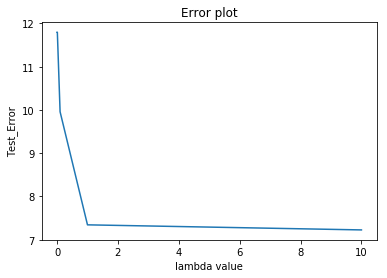

In [70]:
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(lam, error)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()

** Using L2 Regularizer **

In [71]:
clf = LogisticRegression(C = optimal_a1)

clf.fit(tf_X_train,y_train)

pred = clf.predict(tf_X_test)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred) * 100
rec1 = recall_score(y_test, pred) * 100
f11 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc1))
print('\nprecision=%f%%' % (pre1))
print('\nrecall=%f%%' % (rec1))
print('\nF1-Score=%f%%' % (f11))


Accuracy=92.132000%

precision=93.869972%

recall=97.233037%

F1-Score=95.521912%


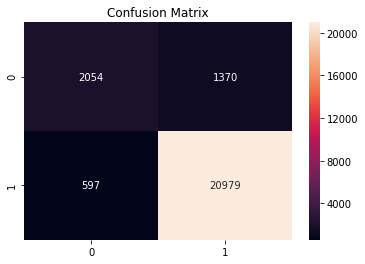

In [72]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

** Using L1 Regularizer **

In [73]:
clf = LogisticRegression(C = optimal_a1 , penalty='l1')

clf.fit(tf_X_train,y_train)

pred = clf.predict(tf_X_test)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=92.080000%

precision=93.976661%

recall=97.043011%

F1-Score=95.485224%


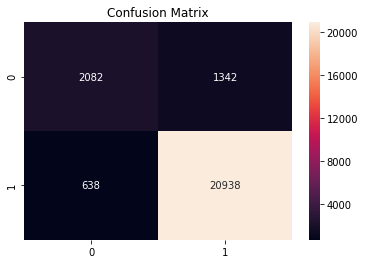

In [74]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [75]:
x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Grid'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

x.add_row([cv,reg1,optimal_a1,acc1,err1,pre1,rec1,f11])
x.add_row([cv,reg2,optimal_a1,acc2,err2,pre2,rec2,f12])

print(x)

+------+-------------+----+-------------+---------------+--------------+-----------+-------------+
|  CV  | Regularizer | C  | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------+-------------+----+-------------+---------------+--------------+-----------+-------------+
| Grid |      L2     | 10 |    92.13    |      7.87     |    93.87     |   97.23   |    95.52    |
| Grid |      L1     | 10 |    92.08    |      7.92     |    93.98     |   97.04   |    95.49    |
+------+-------------+----+-------------+---------------+--------------+-----------+-------------+


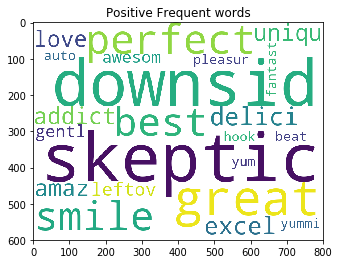

In [76]:
positive_log = np.array(list(map(abs,clf.coef_))).argsort()[0][1970:2000]

pos={}

for index in positive_log:
    for i in tf_idf.vocabulary_:
        if tf_idf.vocabulary_[i] == index:
            pos[i]=clf.coef_[0][index]
            

from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 600,background_color ='white').generate_from_frequencies(pos)
plt.imshow(wordcloud)
plt.title("Positive Frequent words")
plt.show()

### RandomizedSearchCV

In [58]:
clf = LogisticRegression()
param_grid = { 'C':uniform()}
grid = RandomizedSearchCV(estimator = clf,param_distributions=param_grid ,cv = 5,n_jobs = 3)
grid.fit(tf_X_train, y_train)
print("best C = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_
optimal_a1 = a.get('C')

best C =  {'C': 0.9208376313215118}
Accuracy on train data =  92.62133333333334


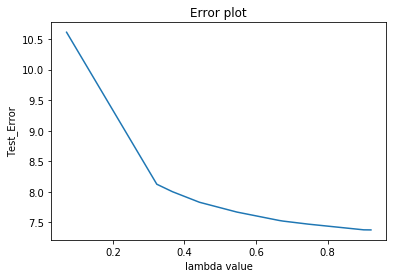

In [59]:
lam =[]
for i in range(10):
    lam.append(grid.cv_results_['params'][i]['C'])
ind = np.argsort(lam)
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
l_values=[]
err=[]
for i in ind:
    l_values.append(lam[i])
    err.append(error[i])
plt.plot(l_values, err)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()

In [60]:
clf = LogisticRegression(C = optimal_a1)

clf.fit(tf_X_train,y_train)

pred = clf.predict(tf_X_test)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred) * 100
rec1 = recall_score(y_test, pred) * 100
f11 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc1))
print('\nprecision=%f%%' % (pre1))
print('\nrecall=%f%%' % (rec1))
print('\nF1-Score=%f%%' % (f11))


Accuracy=91.888000%

precision=92.830850%

recall=98.183166%

F1-Score=95.432021%


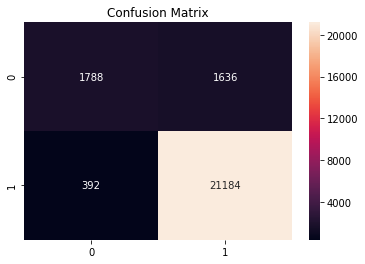

In [61]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [118]:
clf = LogisticRegression(C = optimal_a1 , penalty='l1')

clf.fit(tf_X_train,y_train)

pred = clf.predict(tf_X_test)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=92.076000%

precision=93.250342%

recall=97.905080%

F1-Score=95.521038%


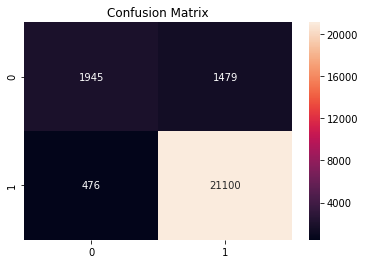

In [63]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [95]:
x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Random'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

x.add_row([cv,reg1,optimal_a1,acc1,err1,pre1,rec1,f11])
x.add_row([cv,reg2,optimal_a1,acc2,err2,pre2,rec2,f12])

print(x)

+--------+-------------+-------------------+-------------+---------------+--------------+-----------+-------------+
|   CV   | Regularizer |         C         | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+--------+-------------+-------------------+-------------+---------------+--------------+-----------+-------------+
| Random |      L2     | 0.493586334683907 |    86.34    |     13.66     |    90.97     |   93.45   |    92.19    |
| Random |      L1     | 0.493586334683907 |     86.6    |      13.4     |    90.52     |   94.36   |     92.4    |
+--------+-------------+-------------------+-------------+---------------+--------------+-----------+-------------+


## Perturbation test on TF-IDF ##

In [119]:
pre_w = clf.coef_[0]

noise_data = tf_X_train.todense()
noise_data[1323] += 0.01

clf = LogisticRegression(C = optimal_a1 , penalty='l1')
clf.fit(noise_data,y_train)

new_w = clf.coef_[0]

per_Change = Weight_change(pre_w,new_w)

print(per_Change)

50.949999999999996


** Even here we get change in weight vectors is high, so features are collinear. **

In [65]:
clf = LogisticRegression(C=100, penalty='l1')
clf.fit(tf_X_train, y_train)

pred = clf.predict(tf_X_test)
ac1 = accuracy_score(y_test, pred) * 100
er1 = np.around(100 - ac1, decimals = 2)

w = clf.coef_
s1 = np.count_nonzero(w)

#======================================================================

clf = LogisticRegression(C=10, penalty='l1')
clf.fit(tf_X_train, y_train)

pred = clf.predict(tf_X_test)
ac2 = accuracy_score(y_test, pred) * 100
er2 = np.around(100 - ac2, decimals = 2)

w = clf.coef_
s2 = np.count_nonzero(w)

#======================================================================

clf = LogisticRegression(C=1, penalty='l1')
clf.fit(tf_X_train, y_train)

pred = clf.predict(tf_X_test)
ac3 = accuracy_score(y_test, pred) * 100
er3 = np.around(100 - ac3, decimals = 2)

w = clf.coef_
s3 = np.count_nonzero(w)

#======================================================================

clf = LogisticRegression(C=0.1, penalty='l1')
clf.fit(tf_X_train, y_train)

pred = clf.predict(tf_X_test)
ac4 = accuracy_score(y_test, pred) * 100
er4 = np.around(100 - ac4, decimals = 2)

w = clf.coef_
s4 = np.count_nonzero(w)

#======================================================================

clf = LogisticRegression(C=0.01, penalty='l1')
clf.fit(tf_X_train, y_train)

pred = clf.predict(tf_X_test)
ac5 = accuracy_score(y_test, pred) * 100
er5 = np.around(100 - ac5, decimals = 2)

w = clf.coef_
s5 = np.count_nonzero(w)

#======================================================================

In [66]:
x = PrettyTable()

c = [100,10,1,0.1,0.01]

x.field_names = ['C','Train_Error(%)','Sparsity']

x.add_row([c[0],er1,s1])
x.add_row([c[1],er2,s2])
x.add_row([c[2],er3,s3])
x.add_row([c[3],er4,s4])
x.add_row([c[4],er5,s5])

print(x)

+------+----------------+----------+
|  C   | Train_Error(%) | Sparsity |
+------+----------------+----------+
| 100  |      7.93      |   1987   |
|  10  |      7.92      |   1891   |
|  1   |      7.84      |   1215   |
| 0.1  |     10.36      |   226    |
| 0.01 |      13.7      |    6     |
+------+----------------+----------+


## AVG Word2Vec ##

In [78]:
from gensim.models import Word2Vec

w2v_data = X_train

splitted = []
for row in w2v_data: 
    splitted.append([word for word in row.split()])     #splitting words
    
train_w2v = Word2Vec(splitted,min_count=5,size=150, workers=4)

avg_X_train = []
for row in splitted:
    vec = np.zeros(150)
    count = 0
    for word in row:
        try:
            vec += train_w2v[word]
            count += 1
        except:
            pass
    avg_X_train.append(vec/count)
    
#================================================================
w2v_data = X_test

splitted = []
for row in w2v_data: 
    splitted.append([word for word in row.split()])     #splitting words
    
train_w2v = Word2Vec(splitted,min_count=5,size=150, workers=4)

avg_X_test = []
for row in splitted:
    vec = np.zeros(150)
    count = 0
    for word in row:
        try:
            vec += train_w2v[word]
            count += 1
        except:
            pass
    if count==0:
        avg_X_test.append(vec)
    else:
        avg_X_test.append(vec/count)

C:\Users\HP\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


** GridSearchCV **

In [83]:
lam = [0.001,0.01,0.1,1,10]
clf = LogisticRegression(class_weight ='balanced')
param_grid = {'C':lam}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 5,n_jobs = 3)
grid.fit(avg_X_train, y_train)
print("best C = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_
optimal_a1 = a.get('C')

best C =  {'C': 10}
Accuracy on train data =  82.77866666666667


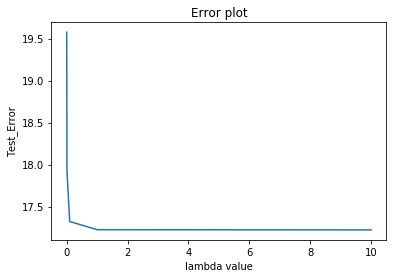

In [84]:
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(lam, error)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()

** Using L2 Reg **

In [85]:
clf = LogisticRegression(C = optimal_a1,class_weight = 'balanced')

clf.fit(avg_X_train,y_train)

pred = clf.predict(avg_X_test)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred) * 100
rec1 = recall_score(y_test, pred) * 100
f11 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc1))
print('\nprecision=%f%%' % (pre1))
print('\nrecall=%f%%' % (rec1))
print('\nF1-Score=%f%%' % (f11))


Accuracy=85.644000%

precision=90.144177%

recall=93.599370%

F1-Score=91.839287%


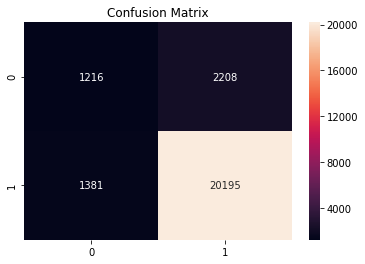

In [86]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

** Using L1 Reg **

In [87]:
clf = LogisticRegression(C = optimal_a1,penalty='l1',class_weight = 'balanced')

clf.fit(avg_X_train,y_train)

pred = clf.predict(avg_X_test)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=85.560000%

precision=90.124174%

recall=93.515944%

F1-Score=91.788736%


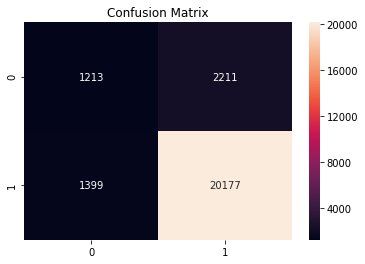

In [88]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [89]:
x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Grid'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

x.add_row([cv,reg1,optimal_a1,acc1,err1,pre1,rec1,f11])
x.add_row([cv,reg2,optimal_a1,acc2,err2,pre2,rec2,f12])

print(x)

+------+-------------+----+-------------+---------------+--------------+-----------+-------------+
|  CV  | Regularizer | C  | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------+-------------+----+-------------+---------------+--------------+-----------+-------------+
| Grid |      L2     | 10 |    85.64    |     14.36     |    90.14     |    93.6   |    91.84    |
| Grid |      L1     | 10 |    85.56    |     14.44     |    90.12     |   93.52   |    91.79    |
+------+-------------+----+-------------+---------------+--------------+-----------+-------------+


** RandomSearchCV **

In [90]:
clf = LogisticRegression()
param_grid = { 'C':uniform()}
grid = RandomizedSearchCV(estimator = clf,param_distributions=param_grid ,cv = 5,n_jobs = 3)
grid.fit(avg_X_train, y_train)
print("best C = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_
optimal_a1 = a.get('C')

best C =  {'C': 0.493586334683907}
Accuracy on train data =  91.35600000000001


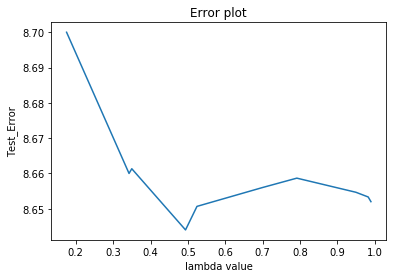

In [91]:
lam =[]
for i in range(10):
    lam.append(grid.cv_results_['params'][i]['C'])
ind = np.argsort(lam)
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
l_values=[]
err=[]
for i in ind:
    l_values.append(lam[i])
    err.append(error[i])
plt.plot(l_values, err)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()

** Using L2 **

In [92]:
clf = LogisticRegression(C = optimal_a1,class_weight = 'balanced')

clf.fit(avg_X_train,y_train)

pred = clf.predict(avg_X_test)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred) * 100
rec1 = recall_score(y_test, pred) * 100
f11 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc1))
print('\nprecision=%f%%' % (pre1))
print('\nrecall=%f%%' % (rec1))
print('\nF1-Score=%f%%' % (f11))


Accuracy=86.336000%

precision=90.967334%

recall=93.446422%

F1-Score=92.190215%


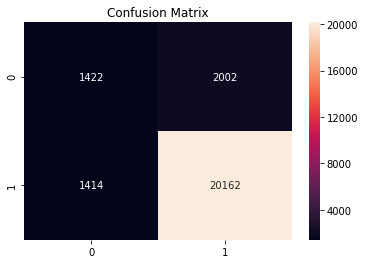

In [93]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

** Using L1 **

In [94]:
clf = LogisticRegression(C = optimal_a1,penalty='l1',class_weight = 'balanced')

clf.fit(avg_X_train,y_train)

pred = clf.predict(avg_X_test)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=86.600000%

precision=90.516628%

recall=94.359473%

F1-Score=92.398112%


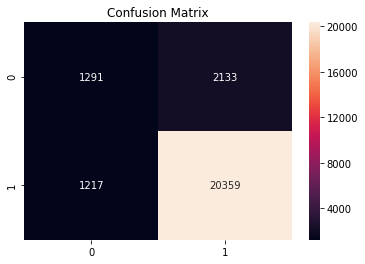

In [96]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [97]:
x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Random'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

x.add_row([cv,reg1,optimal_a1,acc1,err1,pre1,rec1,f11])
x.add_row([cv,reg2,optimal_a1,acc2,err2,pre2,rec2,f12])

print(x)

+--------+-------------+-------------------+-------------+---------------+--------------+-----------+-------------+
|   CV   | Regularizer |         C         | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+--------+-------------+-------------------+-------------+---------------+--------------+-----------+-------------+
| Random |      L2     | 0.493586334683907 |    86.34    |     13.66     |    90.97     |   93.45   |    92.19    |
| Random |      L1     | 0.493586334683907 |     86.6    |      13.4     |    90.52     |   94.36   |     92.4    |
+--------+-------------+-------------------+-------------+---------------+--------------+-----------+-------------+


In [99]:
del avg_X_train
del avg_X_test

** TF-IDF Word2Vec **

In [100]:
tf_w_data = X_train
tf_idf = TfidfVectorizer(max_features=2000)
tf_idf_data = tf_idf.fit_transform(tf_w_data)
tf_train_data = []
tf_idf_data = tf_idf_data.toarray()
i = 0
splitted = []
for row in tf_w_data: 
    splitted.append([word for word in row.split()])
for row in splitted:
    vec = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tf_idf_data[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    count = 0
    tf_idf_sum = 0
    for word in row:
        try:
            count += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[count-1]
            vec += (temp_tfidf[count-1] * train_w2v[word])
        except:
            pass
    #print(vec)
    try:
        vec = (float)(1/tf_idf_sum) * vec
    except:
        pass
    tf_train_data.append(vec)
    i = i + 1
    
    
    
#====================================================================================

tf_w_data = X_test
tf_idf_data = tf_idf.transform(tf_w_data)
tf_test_data = []
tf_idf_data = tf_idf_data.toarray()
i = 0
splitted = []
for row in tf_w_data: 
    splitted.append([word for word in row.split()])
for row in splitted:
    vec = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tf_idf_data[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    count = 0
    tf_idf_sum = 0
    for word in row:
        try:
            count += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[count-1]
            vec += (temp_tfidf[count-1] * train_w2v[word])
        except:
            pass
    try:
        vec = (float)(1/tf_idf_sum) * vec
    except:
        pass
    tf_test_data.append(vec)
    i = i + 1

**GridSearchCV **

In [101]:
lam = [0.001,0.01,0.1,1,10]
clf = LogisticRegression(class_weight ='balanced')
param_grid = {'C':lam}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 5,n_jobs = 3)
grid.fit(tf_train_data, y_train)
print("best C = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_
optimal_a1 = a.get('C')

best C =  {'C': 10}
Accuracy on train data =  77.29466666666667


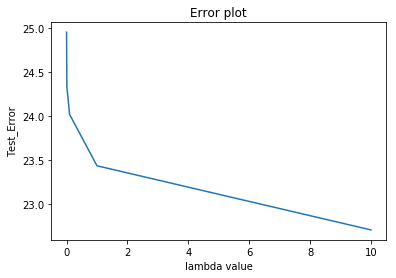

In [102]:
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(lam, error)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()

** Using L2 Reg **

In [103]:
clf = LogisticRegression(C = optimal_a1,class_weight = 'balanced')

clf.fit(tf_train_data,y_train)

pred = clf.predict(tf_test_data)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred) * 100
rec1 = recall_score(y_test, pred) * 100
f11 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc1))
print('\nprecision=%f%%' % (pre1))
print('\nrecall=%f%%' % (rec1))
print('\nF1-Score=%f%%' % (f11))


Accuracy=76.744000%

precision=96.506550%

recall=75.797182%

F1-Score=84.907326%


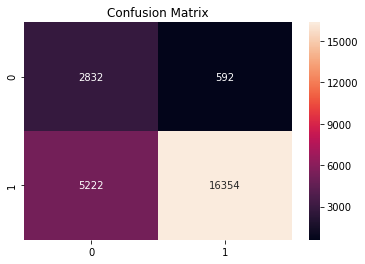

In [104]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

** Using L1 Reg **

In [105]:
clf = LogisticRegression(C = optimal_a1,penalty = 'l1',class_weight = 'balanced')

clf.fit(tf_train_data,y_train)

pred = clf.predict(tf_test_data)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=77.376000%

precision=96.495327%

recall=76.566555%

F1-Score=85.383502%


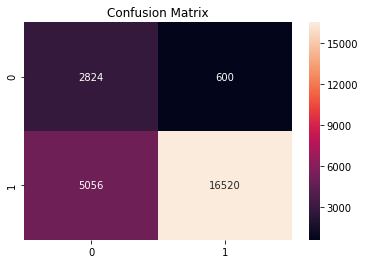

In [106]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [107]:
x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Grid'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

x.add_row([cv,reg1,optimal_a1,acc1,err1,pre1,rec1,f11])
x.add_row([cv,reg2,optimal_a1,acc2,err2,pre2,rec2,f12])

print(x)

+------+-------------+----+-------------+---------------+--------------+-----------+-------------+
|  CV  | Regularizer | C  | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------+-------------+----+-------------+---------------+--------------+-----------+-------------+
| Grid |      L2     | 10 |    76.74    |     23.26     |    96.51     |    75.8   |    84.91    |
| Grid |      L1     | 10 |    77.38    |     22.62     |     96.5     |   76.57   |    85.38    |
+------+-------------+----+-------------+---------------+--------------+-----------+-------------+


** RandomSearchCV **

In [108]:
clf = LogisticRegression()
param_grid = { 'C':uniform()}
grid = RandomizedSearchCV(estimator = clf,param_distributions=param_grid ,cv = 5,n_jobs = 3)
grid.fit(tf_train_data, y_train)
print("best C = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_
optimal_a1 = a.get('C')

best C =  {'C': 0.7470521860621862}
Accuracy on train data =  89.58133333333333


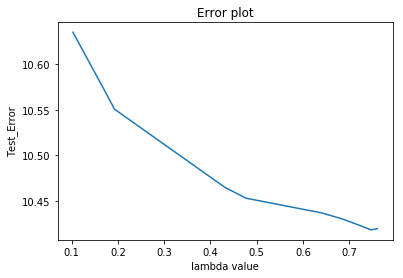

In [109]:
lam =[]
for i in range(10):
    lam.append(grid.cv_results_['params'][i]['C'])
ind = np.argsort(lam)
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
l_values=[]
err=[]
for i in ind:
    l_values.append(lam[i])
    err.append(error[i])
plt.plot(l_values, err)
plt.title('Error plot')
plt.xlabel('lambda value')
plt.ylabel('Test_Error')
plt.show()

** Using L2 Reg **

In [110]:
clf = LogisticRegression(C = optimal_a1,class_weight = 'balanced')

clf.fit(tf_train_data,y_train)

pred = clf.predict(tf_test_data)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred) * 100
rec1 = recall_score(y_test, pred) * 100
f11 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc1))
print('\nprecision=%f%%' % (pre1))
print('\nrecall=%f%%' % (rec1))
print('\nF1-Score=%f%%' % (f11))


Accuracy=75.868000%

precision=96.338918%

recall=74.884131%

F1-Score=84.267348%


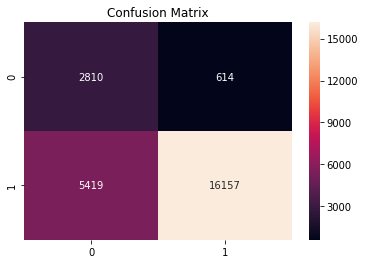

In [111]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

** Using L1 Reg **

In [112]:
clf = LogisticRegression(C = optimal_a1,penalty = 'l1',class_weight = 'balanced')

clf.fit(tf_train_data,y_train)

pred = clf.predict(tf_test_data)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=76.460000%

precision=96.425824%

recall=75.523730%

F1-Score=84.704353%


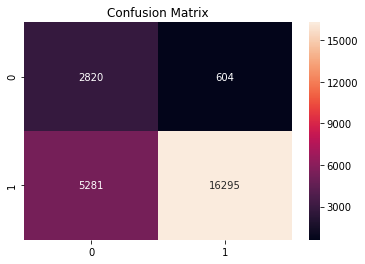

In [113]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [115]:
x = PrettyTable()

reg1 = 'L2'
reg2 = 'L1'
cv = 'Random'
x.field_names = ["CV","Regularizer","C","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

x.add_row([cv,reg1,optimal_a1,acc1,err1,pre1,rec1,f11])
x.add_row([cv,reg2,optimal_a1,acc2,err2,pre2,rec2,f12])

print(x)

+--------+-------------+--------------------+-------------+---------------+--------------+-----------+-------------+
|   CV   | Regularizer |         C          | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+--------+-------------+--------------------+-------------+---------------+--------------+-----------+-------------+
| Random |      L2     | 0.7470521860621862 |    75.87    |     24.13     |    96.34     |   74.88   |    84.27    |
| Random |      L1     | 0.7470521860621862 |    76.46    |     23.54     |    96.43     |   75.52   |     84.7    |
+--------+-------------+--------------------+-------------+---------------+--------------+-----------+-------------+


## Summary And Observations ##

* Considered 100k datapoints for running this model
* Used Pretty table to show all the data in a table format so that user can understand whats going on with every model.
* Done Perturbation test and found out that features are collinear.
* Both BoW and TF-IDF models gave best accuracies compared to AVG W2V and TF-IDF W2V
* Also Proved that as C value decreases sparsity also decreases.
* Plotted Error plots, Heat maps for confusion matrix, Pretty tables for all models.